**Введение**

1. Предсказание фильмов/игр/музыки/видео на основе данных о пользователе  Ассоциация
2. Предсказание и распознавание болезни у пациента  Классификация
3. Предсказание выплаты/невыплаты задолженности     Классификация
4. Прогноз погоды                                   Регрессия
5. Автопилот                                        Классификация

multiclass - один пример имеет один класс
multilabel - один пример может иметь от одного до всех возможных классов

Да. Да, можно - разным диапазонам цены присвоить номера классов. Так это будет задача классификации.

In [1]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('../datasets/train.json')
rows, cols = df.shape
print(f'{rows} rows and {cols} columns')

49352 rows and 15 columns


In [3]:
df.head()
print('price')

price


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


Пустых столбцов нет.

In [5]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


Есть выбросы по сан. узлам и спальням, так как max значительно больше 75%.

In [6]:
df.corr(numeric_only=True)

,bathrooms,bedrooms,latitude,listing_id,longitude,price
bathrooms,1.000000,0.533446,-0.009657,0.000776,0.010393,0.069661
bedrooms,0.533446,1.000000,-0.004745,0.011968,0.006892,0.051788
latitude,-0.009657,-0.004745,1.000000,0.001712,-0.966807,-0.000707
listing_id,0.000776,0.011968,0.001712,1.000000,-0.000907,0.008090
longitude,0.010393,0.006892,-0.966807,-0.000907,1.000000,-0.000087
price,0.069661,0.051788,-0.000707,0.008090,-0.000087,1.000000


Значения коррелируют как положительно, так и отрицательно.

In [7]:
df = df[['bathrooms', 'bedrooms', 'interest_level', 'price']]

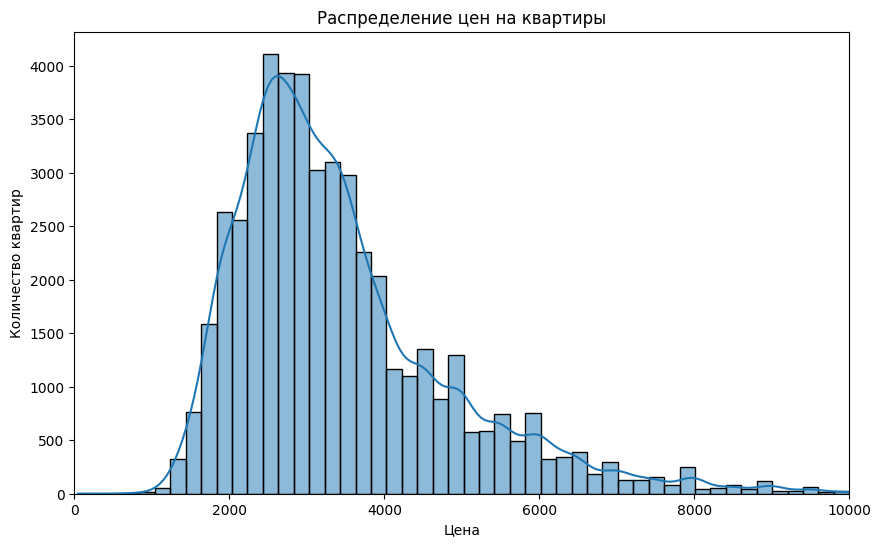

In [8]:
plt.figure(figsize=(10,6))
filtered_df = df[df['price'] < 10000] # фильтр чтобы гистограмма не отображала выбросы
sns.histplot(filtered_df['price'], bins=50, kde=True)

plt.xlim(0, 10000)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена')
plt.ylabel('Количество квартир')
plt.show()


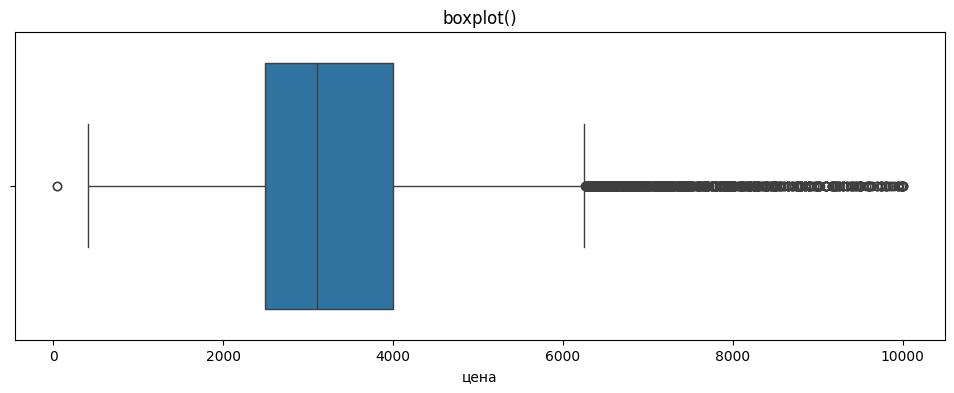

In [9]:
plt.figure(figsize=(12, 4))

filtered_df = df[df['price'] < 10000]
sns.boxplot(x=filtered_df['price'])

plt.title('boxplot()')
plt.xlabel('цена')

plt.show()

Есть много выбросов, так как цены выходят за границы диапазона Q3 + 1.5*IQR, большая часть цен находится в диапазоне от 2500 до 4000, медианная цена около 3000.

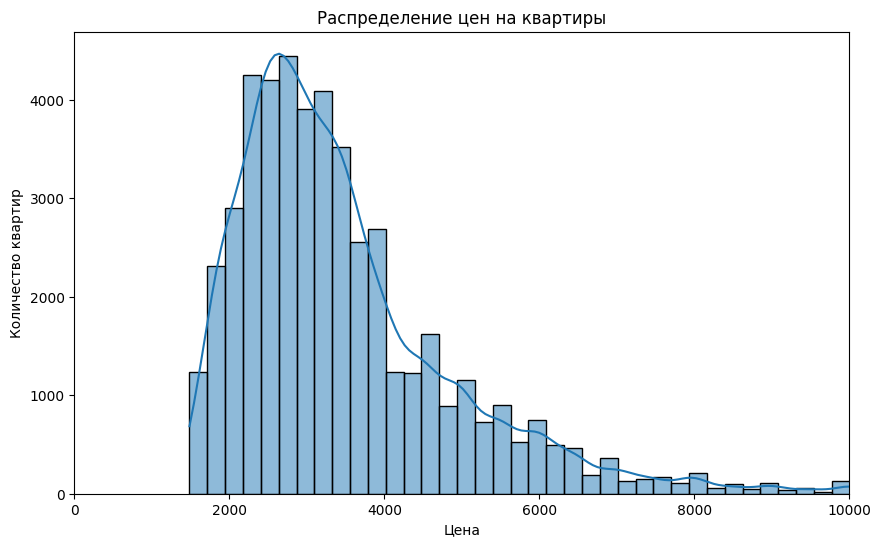

In [10]:
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)
new_df = df[(df['price'] > lower) & (df['price'] < upper)]

plt.figure(figsize=(10,6))
sns.histplot(new_df['price'], bins=50, kde=True)

plt.xlim(0, 10000)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена')
plt.ylabel('Количество квартир')
plt.show()

Часть графика с низкими ценами больше не отображается, потому что квартиры с ценой до ~1600 попали в первый процентиль и были удалены при фильтрации выбросов.

In [11]:
df['interest_level'].dtype

dtype('O')

Значения в interest_level хранятся как строки.

In [12]:
df['interest_level']

4         medium
6            low
9         medium
10        medium
15           low
           ...  
124000       low
124002    medium
124004    medium
124008    medium
124009      high
Name: interest_level, Length: 49352, dtype: object

In [13]:
df['interest_level'].value_counts()

interest_level
low       34284
medium    11229
high       3839
Name: count, dtype: int64

In [14]:
mapping = {'low': 0, 'medium': 1, 'high': 2}
df['interest_level'] = df['interest_level'].map(mapping)
df.head()

,bathrooms,bedrooms,interest_level,price
4,1.0,1,1,2400
6,1.0,2,0,3800
9,1.0,2,1,3495
10,1.5,3,1,3000
15,1.0,0,0,2795


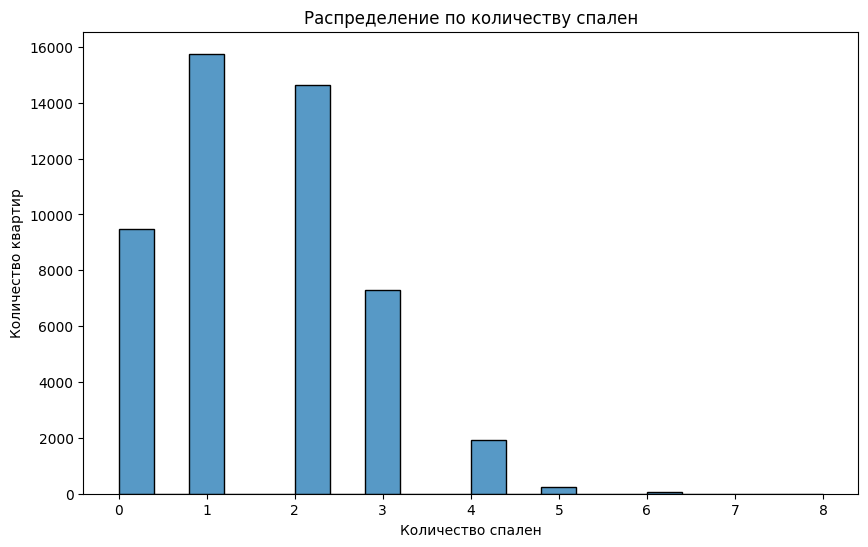

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(df['bedrooms'], bins=20)

plt.title('Распределение по количеству спален')
plt.ylabel('Количество квартир')
plt.xlabel('Количество спален')
plt.show()

Выбросов как таковых нет, просто квартир с количеством спален >5 очень мало.

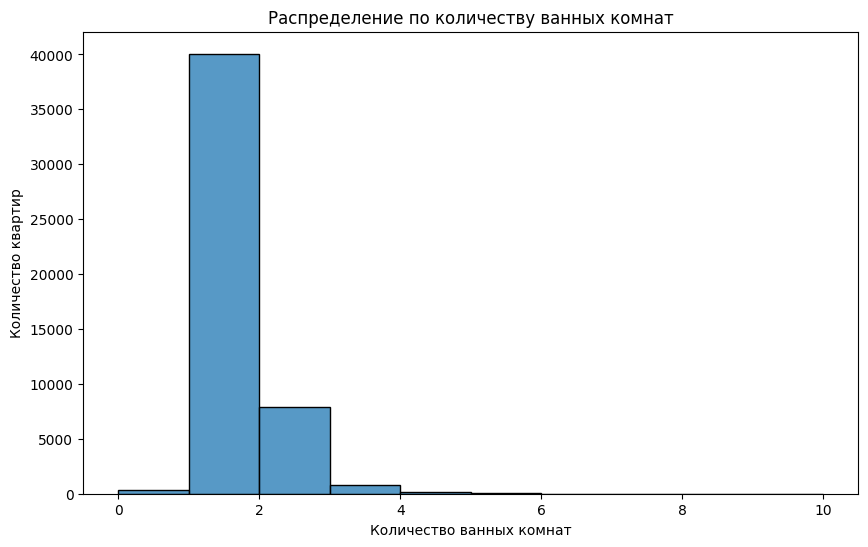

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(df['bathrooms'], bins=10)

plt.title('Распределение по количеству ванных комнат')
plt.ylabel('Количество квартир')
plt.xlabel('Количество ванных комнат')
plt.show()

Ситуация с выбросами та же что со спальнями.

In [17]:
corr_matrix = df.corr()
print(corr_matrix)

                bathrooms  bedrooms  interest_level     price
bathrooms        1.000000  0.533446       -0.082573  0.069661
bedrooms         0.533446  1.000000        0.027293  0.051788
interest_level  -0.082573  0.027293        1.000000 -0.023783
price            0.069661  0.051788       -0.023783  1.000000


<Axes: >

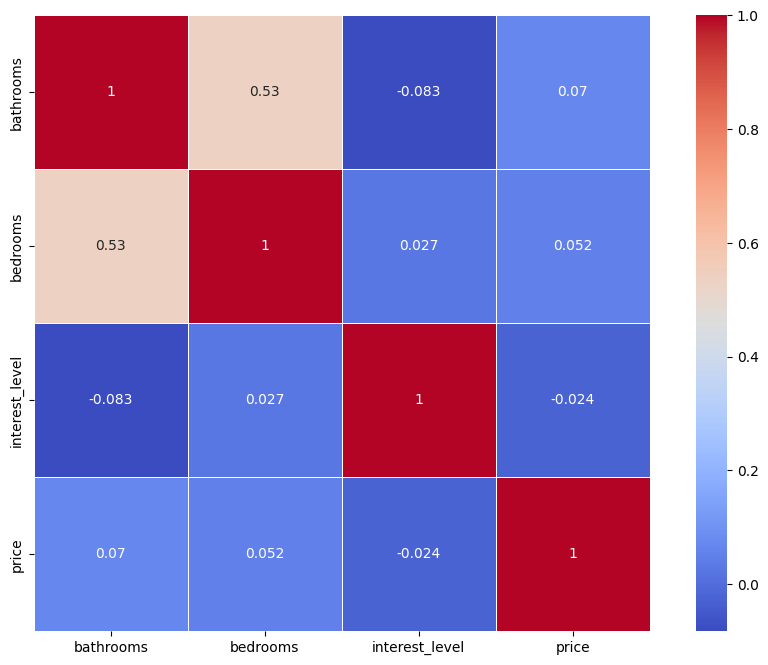

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)

Корреляция между признаками и целевым объектом есть, самое большое значение у количества ванных комнат. Наиболее высокая отрицательная зависимость у уровня интереса.

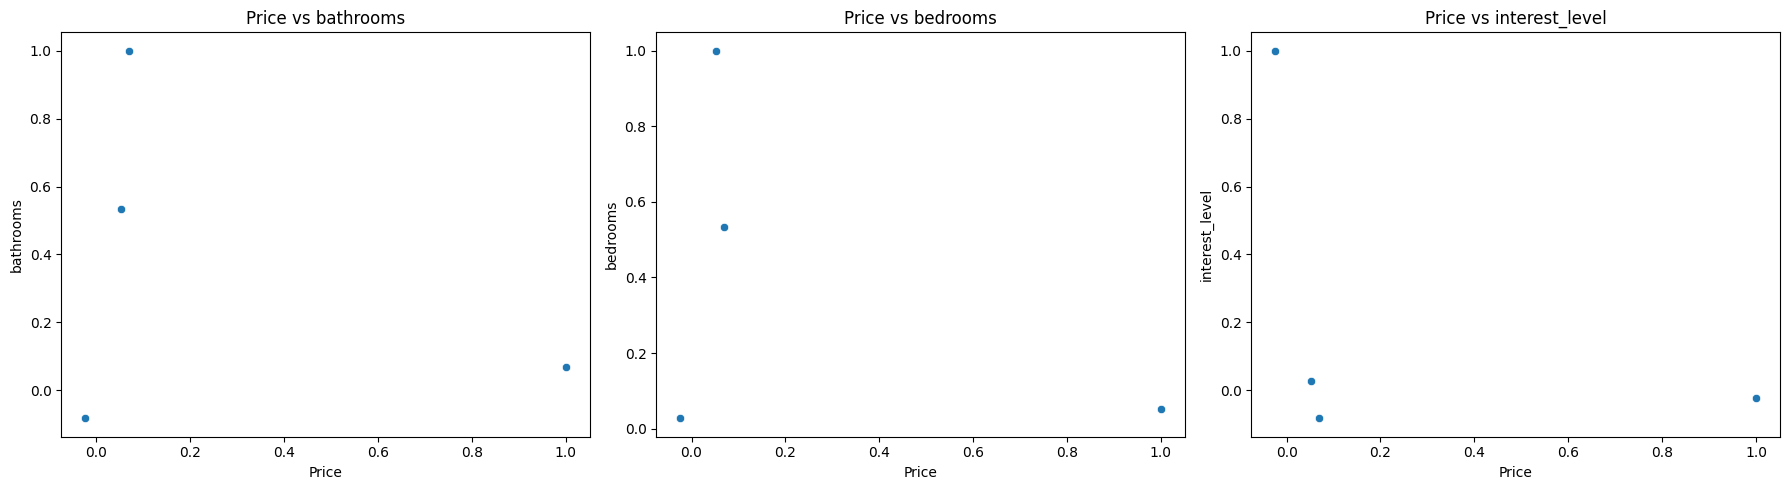

In [19]:
features = ['bathrooms', 'bedrooms', 'interest_level']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    sns.scatterplot(
        data=corr_matrix,
        x='price',
        y=feature,
        ax=axes[i]
    )
    axes[i].set_title(f'Price vs {feature}')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [20]:
df['bathrooms_squared'] = df['bathrooms'] ** 2
df['bedrooms_squared'] = df['bedrooms'] ** 2
df['interest_level_squared'] = df['interest_level'] ** 2

In [21]:
corr_matrix_new = df.corr()
corr_matrix_new

,bathrooms,bedrooms,interest_level,price,bathrooms_squared,bedrooms_squared,interest_level_squared
bathrooms,1.000000,0.533446,-0.082573,0.069661,0.948078,0.576067,-0.074947
bedrooms,0.533446,1.000000,0.027293,0.051788,0.479853,0.928373,0.016339
interest_level,-0.082573,0.027293,1.000000,-0.023783,-0.085297,0.023406,0.945425
price,0.069661,0.051788,-0.023783,1.000000,0.073514,0.052395,-0.021022
bathrooms_squared,0.948078,0.479853,-0.085297,0.073514,1.000000,0.540462,-0.075253
bedrooms_squared,0.576067,0.928373,0.023406,0.052395,0.540462,1.000000,0.013757
interest_level_squared,-0.074947,0.016339,0.945425,-0.021022,-0.075253,0.013757,1.000000


bathroooms_squared и bedrooms_squared стали коррелировать с ценой больше чем не возведенные в квадрат значения. interest_level_squared имеет меньшую отрицательную корреляцию с ценой по сравнению с interest_level.

In [22]:
train = pd.read_json('../datasets/train.json')
test = pd.read_json('../datasets/test.json')

X_train = train.select_dtypes(include=['number']).drop('price', axis=1)
X_test = test.select_dtypes(include=['number']).drop('price', axis=1)

y_train = train['price']
y_test = test['price']

In [23]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [24]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [25]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])

In [26]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

train_preds = lr.predict(X_train_poly)
test_preds = lr.predict(X_test_poly)

train['lr_prediction'] = train_preds
test['lr_prediction'] = test_preds

In [27]:
mae_train = mean_absolute_error(y_train, train_preds)
mae_test = mean_absolute_error(y_test, test_preds)

rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
print(f'RMSE test: {rmse_test:.2f}')
print(f'RMSE train: {rmse_train:.2f}')

MAE train: 1513.11
MAE test: 10437727082730.48
RMSE test: 2851983513294341.50
RMSE train: 22048.11


In [28]:
result_MAE.loc[len(result_MAE)] = ['linear_regression', mae_train, mae_test]
result_RMSE.loc[len(result_RMSE)] = ['linear_regression', rmse_train, rmse_test]

In [29]:
dtree = DecisionTreeRegressor(random_state=21)

param_grid = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_leaf": [1, 3, 5],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["mse", "friedman_mse"]
}

grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train_poly, y_train)

best_params = grid_search.best_params_

print(f'Best params = {best_params}')

/Users/haxarasu/Developer/github/ML_project1/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/haxarasu/Developer/github/ML_project1/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/haxarasu/Developer/github/ML_project1/venv/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~

Best params = {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1}


In [30]:
best_dtree = DecisionTreeRegressor(**best_params, random_state=21)
best_dtree.fit(X_train_poly, y_train)
dtree_train_pred = best_dtree.predict(X_train_poly)
dtree_test_pred = best_dtree.predict(X_test_poly)

train['dtree_prediction'] = dtree_train_pred
test['dtree_prediction'] = dtree_test_pred

In [31]:
mae_train = mean_absolute_error(y_train, dtree_train_pred)
mae_test = mean_absolute_error(y_test, dtree_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, dtree_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, dtree_test_pred))

print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
print(f'RMSE test: {rmse_test:.2f}')
print(f'RMSE train: {rmse_train:.2f}')

MAE train: 785.88
MAE test: 1093.04
RMSE test: 14220.24
RMSE train: 7838.03


In [32]:
result_MAE.loc[len(result_MAE)] = ['decision_tree', mae_train, mae_test]
result_RMSE.loc[len(result_RMSE)] = ['decision_tree', rmse_train, rmse_test]

In [33]:
mean_price_train = y_train.mean()
mean_price_test = y_test.mean()

median_price_train = y_train.median()
median_price_test = y_test.median()

train['naive_prediction_mean'] = mean_price_train
train['naive_prediction_median'] = median_price_train

test['naive_prediction_mean'] = mean_price_test
test['naive_prediction_median'] = median_price_test

In [34]:
mae_train_mean = mean_absolute_error(y_train, np.full_like(y_train, mean_price_train))
mae_test_mean = mean_absolute_error(y_test, np.full_like(y_test, mean_price_train))

mae_train_median = mean_absolute_error(y_train, np.full_like(y_train, median_price_train))
mae_test_median = mean_absolute_error(y_test, np.full_like(y_test, median_price_train))

rmse_train_mean = np.sqrt(mean_squared_error(y_train, np.full_like(y_train, mean_price_train)))
rmse_test_mean = np.sqrt(mean_squared_error(y_test, np.full_like(y_test, mean_price_train)))

rmse_train_median = np.sqrt(mean_squared_error(y_train, np.full_like(y_train, median_price_train)))
rmse_test_median = np.sqrt(mean_squared_error(y_test, np.full_like(y_test, median_price_train)))

In [35]:
result_MAE.loc[len(result_MAE)] = ['naive_mean', mae_train_mean, mae_test_mean]
result_MAE.loc[len(result_MAE)] = ['naive_median', mae_train_median, mae_test_median]

result_RMSE.loc[len(result_RMSE)] = ['naive_mean', rmse_train_mean, rmse_test_mean]
result_RMSE.loc[len(result_RMSE)] = ['naive_median', rmse_train_median, rmse_test_median]

In [36]:
print(result_MAE)

               model        train          test
0  linear_regression  1513.107664  1.043773e+13
1      decision_tree   785.878441  1.093040e+03
2         naive_mean  1549.572358  1.472088e+03
3       naive_median  1400.344403  1.322641e+03


In [37]:
print(result_RMSE)

               model         train          test
0  linear_regression  22048.113065  2.851984e+15
1      decision_tree   7838.026935  1.422024e+04
2         naive_mean  22066.642318  9.713364e+03
3       naive_median  22077.122545  9.731481e+03


Лучшей моделью является DecisionTreeRegressor, так как у нее наименьшие показатели ошибок.